# Recommendation Systems

![Netflix](https://miro.medium.com/max/1400/1*jlQxemlP9Yim_rWTqlCFDQ.png)

![Amazon](images/amazon_recommender.png)

## Objectives

- describe the difference between content-based and collaborative-filtering algorithms
- explain and use the cosine similarity metric
- describe the algorithm of alternating least-squares or singular value decomposition

UNFORTUNATELY the `surprise` library might be broken in y'all's environments. If so, use these two commands in a new terminal window, then reset the kernel:

```
pip uninstall scikit-surprise
conda install -c conda-forge scikit-surprise
```

NOTE! CHECK THE TERMINAL WINDOW OUTPUT! Do NOT let it upgrade to numpy version 1.20!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import surprise

## Intro

Recommender systems can be classified along various lines. One fundamental distinction is **content-based** vs. **collaborative-filtering** systems.

To illustrate this, consider two different strategies: (a) I recommend items to you that are *similar to other items* you've used/bought/read/watched; and (b) I recommend items to you that people *similar to you* have used/bought/read/watched. The first is the **content-based strategy**; the second is the **collaborative-filtering strategy**. 

Another distinction drawn is in whether (a) the system uses existing ratings to compute user-user or item-item similarity, or (b) the system uses machine learning techniques to make predictions. Recommenders of the first sort are called **memory-based**; recommenders of the second sort are called **model-based**.

One last distinction:  **explicit** versus **implicit** ratings.

- **_Explicit_** data is gathered from users when we ask a user to rate an item on some scale
    - Pros: concrete rating system, can assume users actually feel the way they input and thus can extrapolate from those preferences
    - Cons: not all users might input their preferences
- **_Implicit_** data is gathered from users without their direct input - a system logs the actions of a user
    - Pros: Easier to collect automatically, thus have more data from more users without those users needing to go through extra steps
    - Cons: More difficult to work with - how do we know what actions imply preference?
    
[insert comment about y'all filling out surveys here]

## First - The Dumb Model-Less (and Memory-Less) Approach:

### Non-Personalized Recommendations

<img src="images/youtube-nonpersonalizedrecommendations.png" alt="screenshot of youtube's homepage" width=600>

YouTube is notorious for putting non-personalized content on their homepage (although they tailor recommendations in other places)

These recommendations are based purely on the popularity of the item!

#### Advantages
- Super easy (computationally and for the user to understand)
- Items are usually popular for a reason
- No cold-start issue

#### Disadvantages
- Not personalized
- New items won’t gain traction

## Content-Based Systems

The basic idea here is to recommend items to a user that are *similar to* items that the user has already enjoyed. Suppose we represent TV shows as rows, where the columns represent various features of these TV shows. These features might be things like the presence of a certain actor or the show fitting into a particular genre etc. We'll just use binary features here, perhaps the result of some one-hot encoding:

In [2]:
tv_shows = np.array([[0, 1, 1, 0, 1, 1, 1],
                    [0, 0, 0, 1, 1, 1, 0],
                    [1, 1, 1, 0, 0, 1, 1],
                    [0, 1, 1, 1, 0, 0, 1]])

tv_shows

array([[0, 1, 1, 0, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 0],
       [1, 1, 1, 0, 0, 1, 1],
       [0, 1, 1, 1, 0, 0, 1]])

Bob likes the TV Show represented by Row \#1. Which show (row) should we recommend to Bob?

One natural way of measuring the similarity between two vectors is by the **cosine of the angle between them**. Two points near one another in feature space will correspond to vectors that nearly overlap, i.e. vectors that describe a small angle $\theta$. And as $\theta$ decreases, $\cos(\theta)$ *increases*. So we'll be looking for large values of the cosine (which ranges between -1 and 1). We can also think of the cosine between two vectors as the *projection of one vector onto the other*:

![image.png](https://www.oreilly.com/library/view/statistics-for-machine/9781788295758/assets/2b4a7a82-ad4c-4b2a-b808-e423a334de6f.png)

We can use this metric easily if we treat our rows (the items we're comparing for similarity) as vectors: We can calculate the cosine of the angle $\theta$ between two vectors $\vec{a}$ and $\vec{b}$ as follows: $\cos(\theta) = \frac{\vec{a}\cdot\vec{b}}{|\vec{a}||\vec{b}|}$

In [3]:
numerators = np.array([tv_shows[0].dot(tv_show) for tv_show in tv_shows[1:]])
denominators = np.array([np.sqrt(sum(tv_shows[0]**2)) *\
                         np.sqrt(sum(tv_show**2)) for tv_show in tv_shows[1:]])

numerators / denominators

array([0.51639778, 0.8       , 0.67082039])

Since the cosine similarity to Row \#1 is highest for Row \#3, we would recommend this TV show.

### Similarity Metrics

What items are 'similar'? Depends on your similarity metric:

![similarity metrics comparison](images/similaritymetrics.png)

[Image Source: "What Similarity Metric Should You Use for Your Recommendation System?](https://medium.com/bag-of-words/what-similarity-metric-should-you-use-for-your-recommendation-system-b45eb7e6ebd0) <- useful reading!

Those are just 3 examples, there are others (Jaccard index, Euclidian similarity) - but the point is you take some mathematical understanding of the items and find which ones are 'nearby' in some sense.

#### Advantages:
- Easy and transparent
- No cold start issue
- Recommend items to users with unique tastes

#### Disadvantages:
- Requires some type of tagging of items
- Overspecialization to certain types of items

## Collaborative Filtering

Now the idea is to recommend items to a user based on what *similar* users have enjoyed. 

Suppose we have the following recording of explicit ratings of five items by three users:

In [4]:
users = np.array([[5, 4, 3, 4, 5], [3, 1, 1, 2, 5], [4, 2, 3, 1, 4]])

new_user = np.array([5, 0, 0, 0, 0])
users

array([[5, 4, 3, 4, 5],
       [3, 1, 1, 2, 5],
       [4, 2, 3, 1, 4]])

To which user is `new_user` most similar?

One metric is cosine similarity:

In [5]:
new_user_mag = 5

numerators = np.array([new_user.dot(user) for user in users])
denominators = np.array([new_user_mag * np.sqrt(sum(user**2))\
                         for user in users])

numerators / denominators

array([0.52414242, 0.47434165, 0.58976782])

But we could also use another metric, such as Pearson Correlation:

In [6]:
[np.corrcoef(new_user, user)[0, 1] for user in users]

[0.5345224838248488, 0.20044593143431824, 0.5144957554275266]

#### Advantages:

- Finds patterns among users
- Capable of accurately recommending complex items without requiring any 'understanding' of the items themselves

#### Disadvantages:

- Cold start issue - need user behavior or ratings to determine who's similar
- Hard to tell when users will be similar and when they won't

For more on content-based vs. collaborative systems, see [this Wikipedia article](https://en.wikipedia.org/wiki/Collaborative_filtering) and [this blog post](https://towardsdatascience.com/recommendation-systems-models-and-evaluation-84944a84fb8e). [This post](https://dataconomy.com/2015/03/an-introduction-to-recommendation-engines/) on dataconomy is also useful.

***

## Matrix Factorization

Use past behavior of many users (how they've rated many items) to find similarities based on both users and items.

Suppose we start with a matrix $R$ of users and items, where each cell records the ranking the relevant user gave to the relevant item. Very often we'll be able to record this data as a sparse matrix, because many users will not have ranked many items.

Then, we use **_MATH_** (namely, matrix factorization) to fill in those blanks, based upon similar users' ratings of similar items.

More specifically, it finds factor matrices which result in the ratings it has - decomposing the actual Utility Matrix into component pieces that explain it. These component pieces, matrices themselves, can be thought of as 'latent' or 'inherent' features of the items and users! The math then comes in, as we calculate the dot products in order to arrive at our predicted ratings.'

<img src="images/matrixfactorization.png" alt="matrix factorization image, showing the factor matrices" width=700>

[Image Source](https://medium.com/@connectwithghosh/simple-matrix-factorization-example-on-the-movielens-dataset-using-pyspark-9b7e3f567536)

A bit more on Matrix Factorization, from Google's Recommendations Systems crash course: https://developers.google.com/machine-learning/recommendation/collaborative/matrix


#### Advantages:
- Personalized. You’re special!

#### Disadvantages:
- Can require a lot of computation, especially as these matrices get larger
- Cold start: need to have a lot of ratings to be worthwhile
- Popularity Bias: biased towards items that are popular. May not capture people’s unique tastes.

Matrix factorization methods include Singular Value Decomposition (SVD) and Alternating Least Squares (ALS)

## And now, in code!

### Reading in the data and simple EDA

See the documentation for the Surprise library [here](https://surprise.readthedocs.io/en/stable/getting_started.html)!

In [7]:
data = surprise.Dataset.load_builtin('ml-100k')

Now that we've downloaded the data, we can find it in a hidden directory:

In [8]:
df = pd.read_csv('~/.surprise_data/ml-100k/ml-100k/u.data',
                 sep='\t', header=None)
df = df.rename(columns={0: 'userID', 1: 'movieID', 2: 'rating', 3: 'timestamp'})
df

,userID,movieID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [9]:
# check value_counts
ratings = df['rating'].value_counts()
ratings

4    34174
3    27145
5    21201
2    11370
1     6110
Name: rating, dtype: int64

In [10]:
ratings_sorted = dict(zip(ratings.index, ratings))

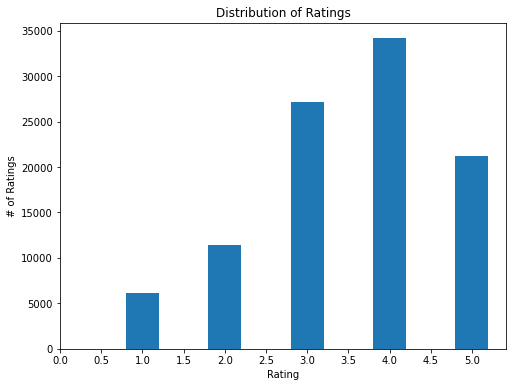

In [11]:
# plot distribution in matplotlib
plt.figure(figsize=(8,6))
plt.bar(ratings_sorted.keys(), ratings_sorted.values(), width=.4)
plt.xticks(np.arange(0, 5.1, step=0.5))
plt.xlabel("Rating")
plt.ylabel("# of Ratings")
plt.title("Distribution of Ratings")
plt.show()

### Users

In [12]:
print("Number of users: ", df.userID.nunique()) 
print("Average Number of Reviews per User: ", df.shape[0]/df.userID.nunique())

Number of users:  943
Average Number of Reviews per User:  106.04453870625663


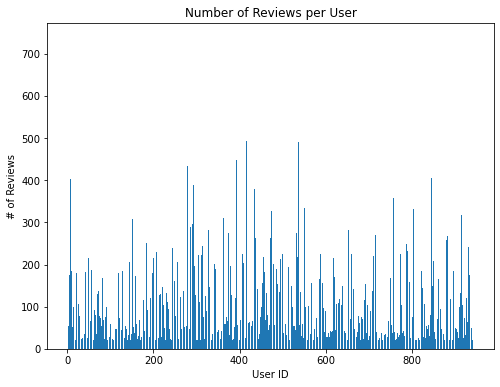

In [13]:
ratings_per_user = df['userID'].value_counts()
ratings_per_user = sorted(list(zip(ratings_per_user.index, ratings_per_user)))

plt.figure(figsize=(8,6))
plt.bar([r[0] for r in ratings_per_user], [r[1] for r in ratings_per_user])
plt.xlabel("User ID")
plt.ylabel("# of Reviews")
plt.title("Number of Reviews per User")
plt.show()

### Movies

In [14]:
print("Number of movies: ", df.movieID.nunique())
print("Average Number of Reviews per Movie: ", df.shape[0]/df.movieID.nunique())

Number of movies:  1682
Average Number of Reviews per Movie:  59.45303210463734


In [15]:
# the movie IDs with the most ratings
df['movieID'].value_counts()[:10]

50     583
258    509
100    508
181    507
294    485
286    481
288    478
1      452
300    431
121    429
Name: movieID, dtype: int64

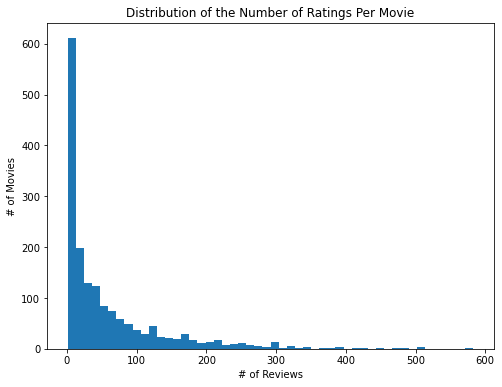

In [16]:
ratings_per_movie = df['movieID'].value_counts()

plt.figure(figsize=(8, 6))
plt.hist(ratings_per_movie, bins=50)
plt.xlabel("# of Reviews")
plt.ylabel("# of Movies")
plt.title("Distribution of the Number of Ratings Per Movie")
plt.show()

## Singular Value Decomposition using Surprise

Written by Yish, thanks <3

One of the easiest libraries to use for recommendation systems is Surprise, which stands for **Simple Python Recommendation System Engine**. Here, we'll code a recommendation system using the Surprise Library's Singular Value Decomposition (SVD) algorithm.

To read more about Surprise's SVD implementation, and its hyperparameters:
https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD

In [17]:
# train-test-split - using surprise!
train, test = surprise.model_selection.train_test_split(data, random_state=42)

In [18]:
# instantiate SVD from surprise
svd = surprise.SVD() # use default values

# now fit to train
svd.fit(train)

### Making Predictions

In [19]:
# Use the `test` method of the model on the test set to get out predictions
predictions = svd.test(test)
# Now check the RMSE of those predictions!
surprise.accuracy.rmse(predictions);

RMSE: 0.9373


In [20]:
# And the MAE
surprise.accuracy.mae(predictions);

MAE:  0.7387


In [21]:
# taking a look at the first 10 rows of our test set
predictions[:10]

[Prediction(uid='907', iid='143', r_ui=5.0, est=5, details={'was_impossible': False}),
 Prediction(uid='371', iid='210', r_ui=4.0, est=4.044631387082572, details={'was_impossible': False}),
 Prediction(uid='218', iid='42', r_ui=4.0, est=3.4860172690708544, details={'was_impossible': False}),
 Prediction(uid='829', iid='170', r_ui=4.0, est=3.966886363746544, details={'was_impossible': False}),
 Prediction(uid='733', iid='277', r_ui=1.0, est=2.8942261865200627, details={'was_impossible': False}),
 Prediction(uid='363', iid='1512', r_ui=1.0, est=3.3713321914399796, details={'was_impossible': False}),
 Prediction(uid='193', iid='487', r_ui=5.0, est=3.6229475045575845, details={'was_impossible': False}),
 Prediction(uid='808', iid='313', r_ui=5.0, est=4.816687776280823, details={'was_impossible': False}),
 Prediction(uid='557', iid='682', r_ui=2.0, est=3.562652594184171, details={'was_impossible': False}),
 Prediction(uid='774', iid='196', r_ui=3.0, est=2.5468994126769187, details={'was_imp

In [22]:
print("Number of users: ", df.userID.nunique()) 
print("Number of movies: ", df.movieID.nunique()) 

Number of users:  943
Number of movies:  1682


In [28]:
# Let's predict! Can play around with the users & items
user = 22
item = 23
svd.predict(user, item)

Prediction(uid=22, iid=23, r_ui=None, est=3.5318875, details={'was_impossible': False})

## More Models? More Models!

Surprise has some basic algorithms - like `BaselineOnly`, which predicts a baseline estimate for a given user an item.

https://surprise.readthedocs.io/en/stable/basic_algorithms.html#surprise.prediction_algorithms.baseline_only.BaselineOnly

In [29]:
base = surprise.BaselineOnly()
base.fit(train)

Estimating biases using als...


In [30]:
surprise.accuracy.mae(base.test(test));

MAE:  0.7490


In [31]:
surprise.accuracy.rmse(base.test(test));

RMSE: 0.9442


#### KNN

Plus there are always neighbors!

In [32]:
knn = surprise.KNNBasic()
knn.fit(train)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [33]:
surprise.accuracy.mae(knn.test(test));

MAE:  0.7727


In [34]:
surprise.accuracy.rmse(knn.test(test));

RMSE: 0.9802


In [35]:
# find the nearest neighbors to an item
knn.get_neighbors(iid=item, k=1) # using same item as earlier

[257]

Want to try more? Let's explore!

https://surprise.readthedocs.io/en/stable/prediction_algorithms_package.html

In [ ]:
# Code here to explore other recommendation models

In [37]:
nmf = surprise.NMF()
nmf.fit(train)

In [38]:
surprise.accuracy.mae(nmf.test(test));

MAE:  0.7593


In [39]:
surprise.accuracy.rmse(nmf.test(test));

RMSE: 0.9658


#### ALS in `pyspark`

We'll talk about Big Data and Spark soon (next week!), but I'll just note here that Spark has a recommendation submodule inside its ml (machine learning) module. Source code for `pyspark`'s version [here](https://spark.apache.org/docs/latest/api/python/_modules/pyspark/ml/recommendation.html).